In [32]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve, auc
from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier


In [38]:
X_train = np.loadtxt("dataset/train/X_train.txt")
y_train = np.loadtxt("dataset/train/y_train.txt", dtype=int) - 1 # Adjust labels to start at 0
X_test = np.loadtxt("dataset/test/X_test.txt")
y_test = np.loadtxt("dataset/test/y_test.txt", dtype=int) - 1 # Adjust labels to start at 0
train_set = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_set = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))


In [64]:
def hinge_loss():
    return

def train(train_set, model, criterion, epochs=20, lr=0.01, reg_lambda=0.001, print_epoch=False):
    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            outputs = model(X)
            if criterion == hinge_loss:
                loss = criterion(outputs, y, model, reg_lambda)
            else:
                loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss)
        if print_epoch:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")
    return losses

def test(test_set, model, criterion, reg_lambda=None, model_name="", show=False):
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    model.eval()
    all_preds = []
    all_probs = []
    y_test = test_set.tensors[1].numpy()
    total_loss = 0
    count = 0
    
    with torch.no_grad():
        for X, y in test_loader:
            outputs = model(X)
            if criterion == hinge_loss:
                loss = criterion(outputs, y, model, reg_lambda)
            else:
                loss = criterion(outputs, y)
            total_loss += loss.item() * X.size(0)
            count += X.size(0)
            preds = torch.argmax(outputs, axis=1).numpy()
            probs = torch.softmax(outputs, axis=1).numpy()
            all_preds.extend(preds)
            all_probs.extend(probs)
    if show:
        print("Accuracy Score:", accuracy_score(y_test, all_preds))
        print(classification_report(y_test, all_preds))
        plot_confusion_matrix(y_test, all_preds, model_name)
        plot_AUC(y_test, all_probs, model_name)
    
    return total_loss / count

def plot_loss(losses, model_name="", title="Loss vs Epochs"):
    plt.figure(figsize=(8, 6))
    plt.plot(losses, marker='o', color='b', label="Average Training Loss")
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title(f"{title} ({model_name})", fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_test, preds, model_name=""):
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
    plt.title(f"Confusion Matrix ({model_name})")
    plt.show()

def plot_AUC(y_test, probs, model_name=""):
    num_classes = len(np.unique(y_test))
    y_one_hot = np.eye(num_classes)[y_test]
    auc_scores = roc_auc_score(y_one_hot, probs, average=None)
    mean_auc = roc_auc_score(y_one_hot, probs, average='macro')
    print(f"AUC Scores (per class): {auc_scores}")
    print(f"Mean AUC: {mean_auc:.4f}")

    for i in range(y_one_hot.shape[1]):
        precision, recall, _ = precision_recall_curve(y_one_hot[:, i], np.array(probs)[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"Class {i} (AUC={pr_auc:.2f})")
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve ({model_name})")
    plt.legend()
    plt.grid()
    plt.show()

def cross_validation_pytorch(model_func, criterion, train_set, lrs, lambdas=None, model_name=""):
    kf = KFold(n_splits=5, shuffle=True)
    best_loss = float('inf')
    best_hyperparams = {}

    for lr in lrs:
        for lambda_val in ([lambdas] if lambdas is not None else [None]):
            fold_losses = []
            for fold, (train_idx, val_idx) in enumerate(kf.split(train_set)):
                X_train_sub = torch.tensor(X_train[train_idx], dtype=torch.float32)
                y_train_sub = torch.tensor(y_train[train_idx], dtype=torch.long)
                X_val_sub = torch.tensor(X_train[val_idx], dtype=torch.float32)
                y_val_sub = torch.tensor(y_train[val_idx], dtype=torch.long)
                train_sub = TensorDataset(X_train_sub, y_train_sub)
                val_sub = TensorDataset(X_val_sub, y_val_sub)

                model = model_func
                train(train_sub, model, criterion, lr=lr, reg_lambda=lambda_val)
                val_loss = test(val_sub, model, criterion, reg_lambda=lambda_val, model_name=model_name)
                fold_losses.append(val_loss)

            mean_loss = np.mean(fold_losses)
            hyperparams = {"lr": lr, "reg_lambda": lambda_val}
            print(f"Hyperparameters: {hyperparams}, Mean Validation Loss: {mean_loss:.4f}")

            if mean_loss < best_loss:
                best_loss = mean_loss
                best_hyperparams = {"lr": lr, "reg_lambda": lambda_val}

    print(f"Best Hyperparameters: {best_hyperparams}, Best Loss: {best_loss:.4f}")
    
    model = model_func
    train_losses = train(train_set, model, criterion, lr=lr, reg_lambda=lambda_val)
    test(test_set, model, criterion, model_name=model_name, show=True)
    plot_loss(train_losses, model_name)


In [ ]:
class FCNet(nn.Module):
    def __init__(self, input_size, num_classes=6):
        super(FCNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

lrs = np.linspace(0.01, 0.1, 5)
cross_validation_pytorch(FCNet(X_train.shape[1]), nn.CrossEntropyLoss(), train_set, lrs, model_name="FCNet")

# fc_model = FCNet(X_train.shape[1])
# train_losses = train(train_set, fc_model, criterion, lr=best_hyperparams["lr"])
# test(test_set, fc_model, criterion, model_name="FCNet", show=True)
# plot_loss(train_losses, "FCNet")

# lrs = np.linspace(0.01, 0.1, 5)
# k_folds = 5
# kf = KFold(n_splits=k_folds, shuffle=True)

# best_loss = float('inf')
# best_lr = None

# for lr in lrs:
#     fold_losses = []
#     for fold, (train_idx, val_idx) in enumerate(kf.split(train_set)):
#         X_train_sub = torch.tensor(X_train[train_idx], dtype=torch.float32)
#         y_train_sub = torch.tensor(y_train[train_idx], dtype=torch.long)
#         X_val_sub = torch.tensor(X_train[val_idx], dtype=torch.float32)
#         y_val_sub = torch.tensor(y_train[val_idx], dtype=torch.long)
#         train_sub = TensorDataset(X_train_sub, y_train_sub)
#         val_sub = TensorDataset(X_val_sub, y_val_sub)
        
#         FC_model = FCNet(input_size)
#         train_losses = train(train_sub, FC_model, criterion, lr=lr)
#         val_loss = test(val_sub, FC_model, criterion, model_name="FCNet")
#         fold_losses.append(val_loss)
#         # print(f"Fold {fold + 1}/{k_folds}, Learning Rate: {lr:.4f}, Validation Loss: {val_loss:.4f}")

#     mean_loss = np.mean(fold_losses)
#     print(f"Learning Rate: {lr:.4f}, Mean Validation Loss: {mean_loss:.4f}")
#     if mean_loss  < best_loss:
#         best_loss = mean_loss 
#         best_lr = lr

# print(f"Best Learning Rate: {best_lr:.4f}, Best Loss: {best_loss:.4f}")

# fc_model = FCNet(input_size)
# train_losses = train(train_set, FC_model, criterion, lr=best_lr)
# test(test_set, FC_model, criterion, model_name="FCNet", show=True)

# plot_loss(train_losses, "FCNet")

Hyperparameters: {'lr': np.float64(0.01), 'reg_lambda': None}, Mean Validation Loss: 0.1299


Learning Rate: 0.0010, Lambda: 0.0010s, Mean Validation Loss: 16.3969
Learning Rate: 0.0010, Lambda: 0.0033s, Mean Validation Loss: 17.1783
Learning Rate: 0.0010, Lambda: 0.0055s, Mean Validation Loss: 17.4339
Learning Rate: 0.0010, Lambda: 0.0078s, Mean Validation Loss: 24.9406
Learning Rate: 0.0010, Lambda: 0.0100s, Mean Validation Loss: 18.8633
Learning Rate: 0.0033, Lambda: 0.0010s, Mean Validation Loss: 21.2683
Learning Rate: 0.0033, Lambda: 0.0033s, Mean Validation Loss: 23.2148
Learning Rate: 0.0033, Lambda: 0.0055s, Mean Validation Loss: 35.8631
Learning Rate: 0.0033, Lambda: 0.0078s, Mean Validation Loss: 28.0400
Learning Rate: 0.0033, Lambda: 0.0100s, Mean Validation Loss: 40.3314
Learning Rate: 0.0055, Lambda: 0.0010s, Mean Validation Loss: 24.8996
Learning Rate: 0.0055, Lambda: 0.0033s, Mean Validation Loss: 38.2936
Learning Rate: 0.0055, Lambda: 0.0055s, Mean Validation Loss: 28.0136
Learning Rate: 0.0055, Lambda: 0.0078s, Mean Validation Loss: 40.8684
Learning Rate: 0.005

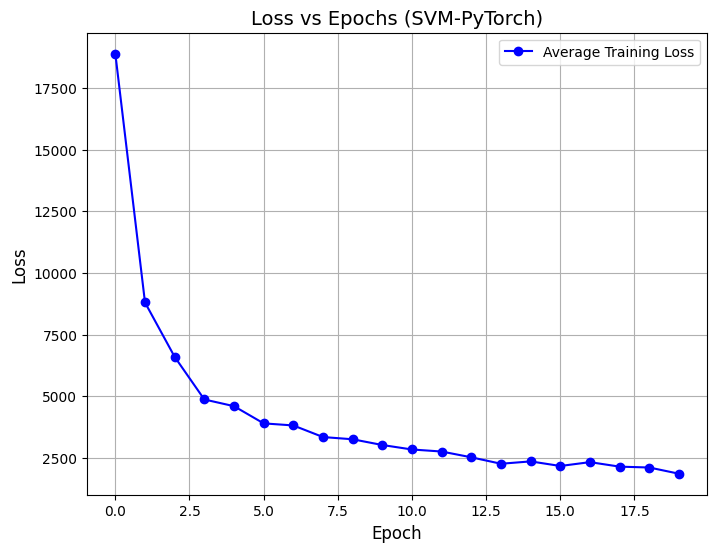

In [ ]:
class SVM(nn.Module):
    def __init__(self, input_size, num_classes=6):
        super(SVM, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

def hinge_loss(output, y, model, reg_lambda):
    y_one_hot = torch.zeros_like(output)
    y_one_hot.scatter_(1, y.view(-1, 1), 1) # Convert labels 0-5 to one-hot encoding
    y_one_hot = 2 * y_one_hot - 1  # Convert to {-1, 1} for each class

    loss = torch.sum(torch.clamp(1 - y_one_hot * output, min=0))
    reg_term = reg_lambda * torch.sum(model.linear.weight ** 2)
    return loss + reg_term

input_size = X_train.shape[1]
criterion = hinge_loss
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

lrs = np.linspace(0.001, 0.01, 5)
lambdas = np.linspace(0.001, 0.01, 5)

best_loss = float('inf')
best_lr = None
best_lambda = None

for lr in lrs:
    for reg_lambda in lambdas:
        fold_losses = []
        for fold, (train_idx, val_idx) in enumerate(kf.split(train_set)):
            X_train_sub = torch.tensor(X_train[train_idx], dtype=torch.float32)
            y_train_sub = torch.tensor(y_train[train_idx], dtype=torch.long)
            X_val_sub = torch.tensor(X_train[val_idx], dtype=torch.float32)
            y_val_sub = torch.tensor(y_train[val_idx], dtype=torch.long)
            train_sub = TensorDataset(X_train_sub, y_train_sub)
            val_sub = TensorDataset(X_val_sub, y_val_sub)
            
            SVM_model = SVM(input_size)
            train_losses = train(train_sub, SVM_model, criterion, lr=lr)
            val_loss = test(val_sub, SVM_model, criterion, reg_lambda, model_name="SVM-PyTorch")
            fold_losses.append(val_loss)
            # print(f"Fold {fold + 1}/{k_folds}, Learning Rate: {lr:.4f}, Lambda: {reg_lambda:.4f}, Validation Loss: {val_loss:.4f}")

        mean_loss = np.mean(fold_losses)
        print(f"Learning Rate: {lr:.4f}, Lambda: {reg_lambda:.4f}s, Mean Validation Loss: {mean_loss:.4f}")
        if mean_loss  < best_loss:
            best_loss = mean_loss 
            best_lr = lr
            best_lambda = reg_lambda

print(f"Best Learning Rate: {best_lr:.4f}, Best Lambda: {best_lambda:.4f}, Best Loss: {best_loss:.4f}")

SVM_model = SVM(input_size)
train_losses = train(train_set, SVM_model, criterion, lr=best_lr, reg_lambda=best_lambda)
test(test_set, SVM_model, criterion, reg_lambda=best_lambda, model_name="SVM-PyTorch", show=True)

plot_loss(train_losses, "SVM-PyTorch")


Fold 1/5, C: 10.0000, Validation Accuracy: 0.9864
Fold 2/5, C: 10.0000, Validation Accuracy: 0.9905
Fold 3/5, C: 10.0000, Validation Accuracy: 0.9864
Fold 4/5, C: 10.0000, Validation Accuracy: 0.9878
Fold 5/5, C: 10.0000, Validation Accuracy: 0.9878
C=10.0000, Mean Validation Accuracy: 0.9878
Fold 1/5, C: 16.6810, Validation Accuracy: 0.9912
Fold 2/5, C: 16.6810, Validation Accuracy: 0.9891
Fold 3/5, C: 16.6810, Validation Accuracy: 0.9810
Fold 4/5, C: 16.6810, Validation Accuracy: 0.9891
Fold 5/5, C: 16.6810, Validation Accuracy: 0.9925
C=16.6810, Mean Validation Accuracy: 0.9886
Fold 1/5, C: 27.8256, Validation Accuracy: 0.9905
Fold 2/5, C: 27.8256, Validation Accuracy: 0.9905
Fold 3/5, C: 27.8256, Validation Accuracy: 0.9878
Fold 4/5, C: 27.8256, Validation Accuracy: 0.9918
Fold 5/5, C: 27.8256, Validation Accuracy: 0.9891
C=27.8256, Mean Validation Accuracy: 0.9899
Fold 1/5, C: 46.4159, Validation Accuracy: 0.9905
Fold 2/5, C: 46.4159, Validation Accuracy: 0.9891
Fold 3/5, C: 46.41

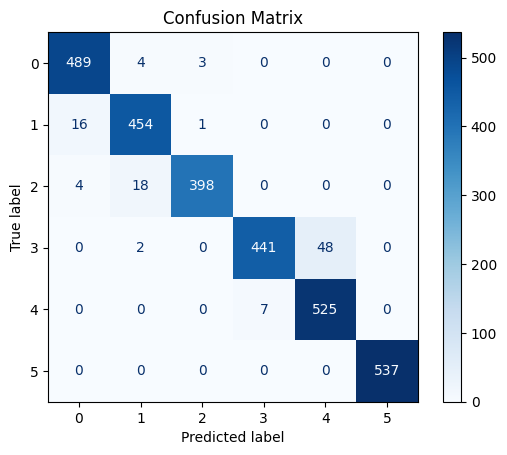

AUC Scores (per class): [0.99964876 0.99893157 0.99934517 0.99475328 0.99767431 1.        ]
Mean AUC: 0.9984


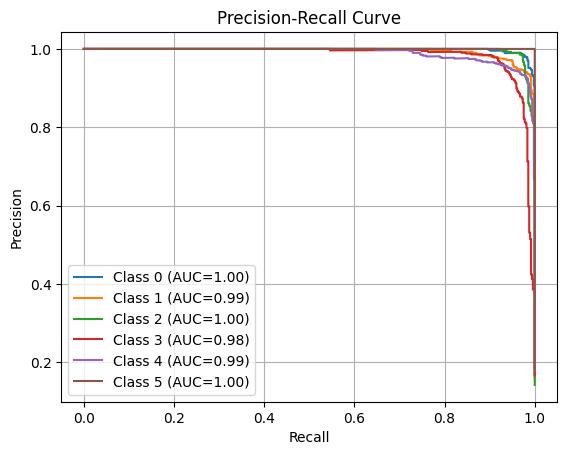

In [ ]:
def sklearn_svm_model(X_train, y_train, X_test, y_test):
    C_range=np.logspace(1, 3, 10)
    k_folds = 5
    kf = KFold(n_splits=k_folds, shuffle=True)
    best_C = None
    best_score = 0
    fold_accuracies = []
    
    for C in C_range:
        fold_scores = []
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            X_train_sub = X_train[train_idx]
            y_train_sub = y_train[train_idx]
            X_val_sub = X_train[val_idx]
            y_val_sub = y_train[val_idx]
            
            sk_SVM_model = SVC(kernel='rbf', C=C, probability=True)
            sk_SVM_model.fit(X_train_sub, y_train_sub)
            
            sk_SVM_preds = sk_SVM_model.predict(X_val_sub)
            accuracy = accuracy_score(y_val_sub, sk_SVM_preds)
            fold_scores.append(accuracy)
            # print(f"Fold {fold + 1}/{k_folds}, C: {C:.4f}, Validation Accuracy: {accuracy:.4f}")
        
        mean_accuracy = np.mean(fold_scores)
        fold_accuracies.append(mean_accuracy)
        print(f"C={C:.4f}, Mean Validation Accuracy: {mean_accuracy:.4f}")
        
        if mean_accuracy > best_score:
            best_score = mean_accuracy
            best_C = C
    
    print(f"Best C parameter: {best_C}, Best Cross-Validation Accuracy: {best_score:.4f}")
    
    final_model = SVC(kernel='rbf', C=best_C, probability=True)
    final_model.fit(X_train, y_train)
    
    sk_SVM_preds = final_model.predict(X_test)
    sk_SVM_probs = final_model.predict_proba(X_test)
    
    print("SVM Model Accuracy on Test Set:", accuracy_score(y_test, sk_SVM_preds))
    print(classification_report(y_test, sk_SVM_preds))
    
    plot_confusion_matrix(y_test, sk_SVM_preds, "SVM-Scikit Learn")
    plot_AUC(y_test, sk_SVM_probs, "SVM-Scikit Learn")
    
    return final_model

sk_SVM_model = sklearn_svm_model(X_train, y_train, X_test, y_test)


In [ ]:
# def sklearn_random_forest_model(X_train, y_train, X_test, y_test):
#     RF_model = RandomForestClassifier(
#         n_estimators=100,
#         max_depth=None
#     )
#     RF_model.fit(X_train, y_train)

#     RF_pred = RF_model.predict(X_test)
#     RF_prob = RF_model.predict_proba(X_test)

#     accuracy = accuracy_score(y_test, RF_pred)
#     print(f"Accuracy: {accuracy:.4f}")
#     print("Classification Report:")
#     print(classification_report(y_test, RF_pred))

#     plot_confusion_matrix(y_test, RF_pred)
#     plot_AUC(y_test, RF_prob)
#     return RF_model

# RF_model = sklearn_random_forest_model(X_train, y_train, X_test, y_test)

Fold 5/5, max depth: 5.0000, min samples split: 5.0000, Validation Accuracy: 0.9068
max_depth=5, min_samples_split=5, Mean Validation Accuracy: 0.9056
Fold 5/5, max depth: 5.0000, min samples split: 10.0000, Validation Accuracy: 0.8980
max_depth=5, min_samples_split=10, Mean Validation Accuracy: 0.9060
Fold 5/5, max depth: 5.0000, min samples split: 15.0000, Validation Accuracy: 0.8925
max_depth=5, min_samples_split=15, Mean Validation Accuracy: 0.9027
Fold 5/5, max depth: 10.0000, min samples split: 5.0000, Validation Accuracy: 0.9456
max_depth=10, min_samples_split=5, Mean Validation Accuracy: 0.9436
Fold 5/5, max depth: 10.0000, min samples split: 10.0000, Validation Accuracy: 0.9429
max_depth=10, min_samples_split=10, Mean Validation Accuracy: 0.9419
Fold 5/5, max depth: 10.0000, min samples split: 15.0000, Validation Accuracy: 0.9483
max_depth=10, min_samples_split=15, Mean Validation Accuracy: 0.9418
Fold 5/5, max depth: 15.0000, min samples split: 5.0000, Validation Accuracy: 0.

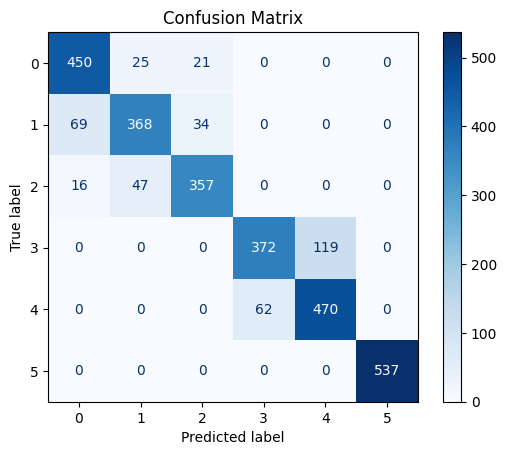

AUC Scores (per class): [0.94978679 0.86666006 0.92121139 0.91247255 0.92907813 1.        ]
Mean AUC: 0.9299


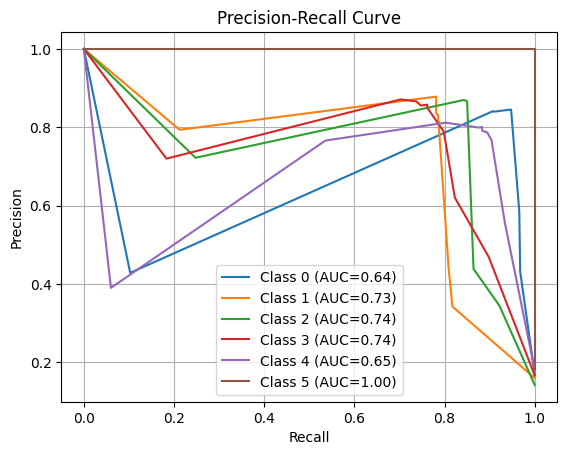

In [ ]:
def sklearn_decision_tree_model(X_train, y_train, X_test, y_test):
    max_depth_range = [5, 10, 15, 20]
    min_samples_split_range = [5, 10, 15]
    k_folds = 5
    kf = KFold(n_splits=k_folds, shuffle=True)
    best_param = None
    best_score = 0
    fold_accuracies = []
    
    for max_depth in max_depth_range:
        for min_samples_split in min_samples_split_range:
            fold_scores = []
            for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
                X_train_sub = X_train[train_idx]
                y_train_sub = y_train[train_idx]
                X_val_sub = X_train[val_idx]
                y_val_sub = y_train[val_idx]

                dt_model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
                dt_model.fit(X_train_sub, y_train_sub)

                dt_preds = dt_model.predict(X_val_sub)
                accuracy = accuracy_score(y_val_sub, dt_preds)
                fold_scores.append(accuracy)
                # print(f"Fold {fold + 1}/{k_folds}, max depth: {max_depth:.4f}, min samples split: {min_samples_split:.4f}, Validation Accuracy: {accuracy:.4f}")

            mean_accuracy = np.mean(fold_scores)
            fold_accuracies.append(mean_accuracy)
            print(f"max_depth={max_depth}, min_samples_split={min_samples_split}, Mean Validation Accuracy: {mean_accuracy:.4f}")
            
            if mean_accuracy > best_score:
                best_score = mean_accuracy
                best_param = (max_depth, min_samples_split)
    
    print(f"Best Parameters: max_depth={best_param[0]}, min_samples_split={best_param[1]}")
    print(f"Best Cross-Validation Accuracy: {best_score:.4f}")
    
    final_model = DecisionTreeClassifier(max_depth=best_param[0], min_samples_split=best_param[1], random_state=42)
    final_model.fit(X_train, y_train)
    
    dt_preds = final_model.predict(X_test)
    dt_preds_prob = final_model.predict_proba(X_test)
    
    print("Decision Tree Model Accuracy on Test Set:", accuracy_score(y_test, dt_preds))
    print(classification_report(y_test, dt_preds))
    
    plot_confusion_matrix(y_test, dt_preds, "Decision Tree")
    plot_AUC(y_test, dt_preds_prob, "Decision Tree")
    
    return final_model

dt_model = sklearn_decision_tree_model(X_train, y_train, X_test, y_test)

Fold 1/5, n_neighbors: 1.0000, Validation Accuracy: 0.9837
Fold 2/5, n_neighbors: 1.0000, Validation Accuracy: 0.9871
Fold 3/5, n_neighbors: 1.0000, Validation Accuracy: 0.9864
Fold 4/5, n_neighbors: 1.0000, Validation Accuracy: 0.9837
Fold 5/5, n_neighbors: 1.0000, Validation Accuracy: 0.9871
n_neighbors=1, Mean Validation Accuracy: 0.9856
Fold 1/5, n_neighbors: 2.0000, Validation Accuracy: 0.9782
Fold 2/5, n_neighbors: 2.0000, Validation Accuracy: 0.9830
Fold 3/5, n_neighbors: 2.0000, Validation Accuracy: 0.9884
Fold 4/5, n_neighbors: 2.0000, Validation Accuracy: 0.9830
Fold 5/5, n_neighbors: 2.0000, Validation Accuracy: 0.9912
n_neighbors=2, Mean Validation Accuracy: 0.9848
Fold 1/5, n_neighbors: 3.0000, Validation Accuracy: 0.9748
Fold 2/5, n_neighbors: 3.0000, Validation Accuracy: 0.9905
Fold 3/5, n_neighbors: 3.0000, Validation Accuracy: 0.9844
Fold 4/5, n_neighbors: 3.0000, Validation Accuracy: 0.9810
Fold 5/5, n_neighbors: 3.0000, Validation Accuracy: 0.9803
n_neighbors=3, Mean

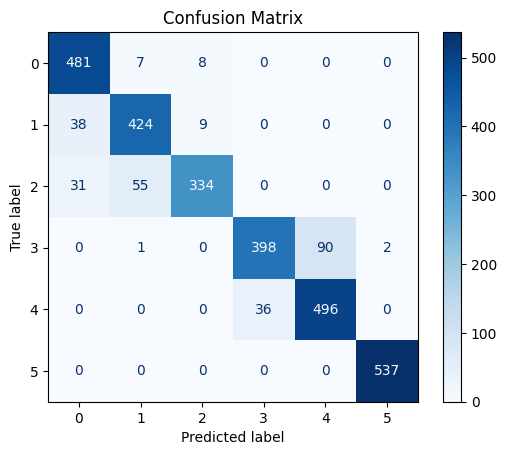

AUC Scores (per class): [0.98800646 0.97665573 0.94561168 0.9726386  0.98411674 0.99999768]
Mean AUC: 0.9778


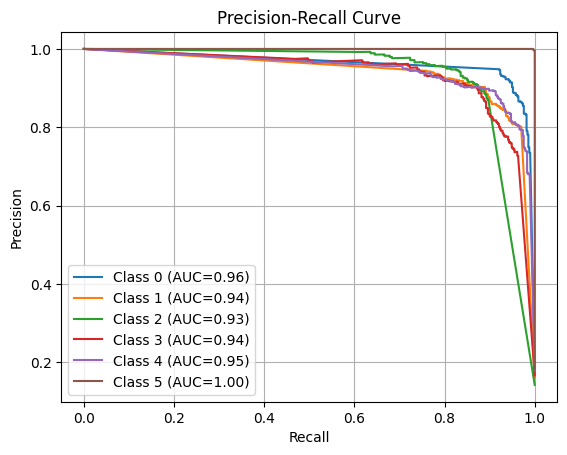

In [ ]:
def sklearn_knn_model(X_train, y_train, X_test, y_test):
    n_neighbors_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    k_folds = 5
    kf = KFold(n_splits=k_folds, shuffle=True)
    best_param = None
    best_score = 0
    fold_accuracies = []
    
    for n_neighbors in n_neighbors_range:
        fold_scores = []
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            X_train_sub = X_train[train_idx]
            y_train_sub = y_train[train_idx]
            X_val_sub = X_train[val_idx]
            y_val_sub = y_train[val_idx]

            knn_model = KNeighborsClassifier(n_neighbors=n_neighbors, metric='manhattan', weights='distance')
            knn_model.fit(X_train_sub, y_train_sub)
            
            knn_preds = knn_model.predict(X_val_sub)
            accuracy = accuracy_score(y_val_sub, knn_preds)
            fold_scores.append(accuracy)
            # print(f"Fold {fold + 1}/{k_folds}, n_neighbors: {n_neighbors:.4f}, Validation Accuracy: {accuracy:.4f}")
        
        mean_accuracy = np.mean(fold_scores)
        fold_accuracies.append(mean_accuracy)
        print(f"n_neighbors={n_neighbors}, Mean Validation Accuracy: {mean_accuracy:.4f}")
        
        if mean_accuracy > best_score:
            best_score = mean_accuracy
            best_param = n_neighbors
    
    print(f"Best n_neighbors parameter: {best_param}, Best Cross-Validation Accuracy: {best_score:.4f}")
    
    final_model = KNeighborsClassifier(n_neighbors=best_param, metric='manhattan', weights='distance')
    final_model.fit(X_train, y_train)
    
    knn_preds = final_model.predict(X_test)
    knn_preds_prob = final_model.predict_proba(X_test)
    
    print("K-NN Model Accuracy on Test Set:", accuracy_score(y_test, knn_preds))
    print(classification_report(y_test, knn_preds))
    
    plot_confusion_matrix(y_test, knn_preds, "KNN")
    plot_AUC(y_test, knn_preds_prob, "KNN")
    
    return final_model

# Usage
sk_knn_model = sklearn_knn_model(X_train, y_train, X_test, y_test)